In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install fastparquet
!python3 -m pip install  python-snappy
!sudo apt-get install libsnappy-dev
!pip install tensorflow-addons
!python3 -m pip install pyarrow
! pip install hyperas
!pip install --upgrade numpy

     |████████████████████████████████| 1.2 MB 6.5 MB/s 
     |████████████████████████████████| 125 kB 47.3 MB/s 
     |████████████████████████████████| 1.5 MB 40.5 MB/s 
     |████████████████████████████████| 59 kB 6.6 MB/s 
  Created wheel for thrift: filename=thrift-0.15.0-cp37-cp37m-linux_x86_64.whl size=348185 sha256=ea30f2f64163e36ba680e6917f06abdfc2c558bf51925f11f774bf88d86aa260
  Stored in directory: /root/.cache/pip/wheels/ba/1f/8e/e6fd36837eecf3d1f2b23f1729477e8e06558d8d60b7093f51
Successfully built thrift
     |████████████████████████████████| 55 kB 2.2 MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  libsnappy-dev
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 27.2 kB of archives.
After this operation, 108 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libsnappy-dev amd64 1.1.7-1 [27.2 kB]
F

# Import the data 

In [ ]:
import os
import re
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import fastparquet as fp
import matplotlib.pyplot as plt

from time import time
from collections import Counter
from scipy.integrate import trapz
from sklearn.metrics import confusion_matrix, precision_score

# Deep Learning libraries
import tensorflow as tf
from tensorflow_addons.optimizers import RectifiedAdam, Lookahead
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Custom libraries
os.chdir('/content/gdrive/My Drive/phyto_curves_reco')
from losses import CB_loss, categorical_focal_loss
from from_cytoclus_to_curves_values import extract_labeled_curves, extract_non_labeled_curves
from dataset_preprocessing import homogeneous_cluster_names_swings, gen_train_test_valid

current_dir = '/content/gdrive/My Drive/data/SWINGS/L2/Pulse/'

          
os.chdir('/content/gdrive/My Drive/data/SWINGS')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
train = np.load(current_dir + 'train.npz', allow_pickle = True)
valid = np.load(current_dir + 'valid.npz', allow_pickle = True)

X_train = train['X']
X_valid = valid['X']

y_train = train['y']
y_valid = valid['y']

# Free the memory 
del(train)
del(valid)

In [ ]:
# Import the nomenclature created by the "gen_train_test_valid" function
tn = pd.read_csv(current_dir + '/train_test_nomenclature.csv')
tn.columns = ['name', 'id']

In [ ]:
from scipy.integrate import trapz

In [ ]:
wrong_idx = ~((trapz(X_train[:,:,2]) <= 1E3) & (y_train.argmax(1) == 1))
X_train = X_train[wrong_idx]
y_train = y_train[wrong_idx]

In [ ]:
#X_train = X_train[:,:,:4]
#X_valid = X_valid[:,:,:4]

In [ ]:
X_train = X_train / X_train.max()
X_valid = X_valid / X_valid.max()

# Benchmark model

In [ ]:
# Load the model 
from keras.models import load_model
bench_model = load_model('/content/gdrive/My Drive/Models/SWINGS/cnn_HyperCateg41_6')

In [ ]:
for ix, layer in enumerate(bench_model.layers):
    if hasattr(bench_model.layers[ix], 'kernel_initializer') and \
            hasattr(bench_model.layers[ix], 'bias_initializer'):
        weight_initializer = bench_model.layers[ix].kernel_initializer
        bias_initializer = bench_model.layers[ix].bias_initializer

        old_weights, old_biases = bench_model.layers[ix].get_weights()

        bench_model.layers[ix].set_weights([
            weight_initializer(shape=old_weights.shape),
            bias_initializer(shape=len(old_biases))])

In [ ]:
sb_weights = '/content/gdrive/My Drive/Models/SWINGS/small_bench_weights.hdf5'

In [ ]:
N_CLASSES = y_train.shape[1]
max_len = X_train.shape[1]
nb_curves = X_train.shape[2]

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
check = ModelCheckpoint(filepath = sb_weights,\
                        verbose = 1, save_best_only=True)

# Defining the weights: Take the average over SSLAMM data
weights = 0.3
w = 1 / (np.sum(y_valid, axis = 0)) ** weights
w = w / w.sum()
w = dict(zip(range(N_CLASSES),w))

batch_size = 64*4
STEP_SIZE_TRAIN = (len(X_train) // batch_size) + 1
STEP_SIZE_VALID = (len(X_valid) // (128 * 8)) + 1

In [ ]:
'''
result_sb = bench_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), \
                steps_per_epoch = STEP_SIZE_TRAIN, validation_steps = STEP_SIZE_VALID,\
                epochs = 120, class_weight = w, shuffle=True, verbose=2, callbacks = [check, es])
'''
bench_model.load_weights(sb_weights)

# Benchmark big

In [ ]:
bb_weights = '/content/gdrive/My Drive/Models/SWINGS/big_bench_weights.hdf5'

In [ ]:
N_CLASSES = y_train.shape[1]
max_len = X_train.shape[1]
nb_curves = X_train.shape[2]

dp = 0.3358541

sequence_input = tf.keras.layers.Input(shape=(max_len, nb_curves), dtype='float32')

filter_size = 3
x = tf.keras.layers.Conv1D(32, filter_size, activation='relu')(sequence_input)
x = tf.keras.layers.Conv1D(64, filter_size, activation='relu')(x)
x = tf.keras.layers.Conv1D(128, filter_size, activation='relu')(x)

# Average the created features maps
average = tf.keras.layers.GlobalAveragePooling1D()(x)
dense2 = tf.keras.layers.Dense(64, activation='relu')(average) 
drop2 = tf.keras.layers.Dropout(dp)(dense2)
dense3 = tf.keras.layers.Dense(32, activation='relu')(drop2)
drop3 = tf.keras.layers.Dropout(dp)(dense3)
dense4 = tf.keras.layers.Dense(16, activation='relu')(drop3)
drop4 = tf.keras.layers.Dropout(dp)(dense4)

predictions = tf.keras.layers.Dense(N_CLASSES, activation='softmax')(dense2)
bench_big = tf.keras.Model(sequence_input, predictions)

#==================================================
# Specifying the optimizer
#==================================================
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
check = ModelCheckpoint(filepath=bb_weights,\
                        verbose = 1, save_best_only=True)

optim_ch = 'ranger'
lr = 0.007629758 #modif

if optim_ch == 'adam':
    optim = tf.keras.optimizers.Adam(learning_rate = lr)
    sync_period = None
    slow_step_size = None
else:
    sync_period = 3
    slow_step_size = 0.41782
    rad = RectifiedAdam(learning_rate = lr)
    optim = Lookahead(rad, sync_period = sync_period, slow_step_size = slow_step_size)


# Defining the weights: Take the average over SSLAMM data
weights = 0.3
w = 1 / (np.sum(y_valid, axis = 0))**weights
w = w / w.sum()
w = dict(zip(range(N_CLASSES),w))

batch_size = 64*4
STEP_SIZE_TRAIN = (len(X_train) // batch_size) + 1
STEP_SIZE_VALID = (len(X_valid) // (128 * 8)) + 1

bench_big.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optim)

In [ ]:
'''
result_bb = bench_big.fit(X_train, y_train, validation_data=(X_valid, y_valid), \
                steps_per_epoch = STEP_SIZE_TRAIN, validation_steps = STEP_SIZE_VALID,\
                epochs = 120, class_weight = w, shuffle=True, verbose=2, callbacks = [check, es])
'''
bench_big.load_weights(bb_weights)

# VGG small

In [ ]:
vggSmall_weights = '/content/gdrive/My Drive/Models/SWINGS/VGG_small_weights.hdf5'

In [ ]:
N_CLASSES = y_train.shape[1]
max_len = X_train.shape[1]
nb_curves = X_train.shape[2]

dp = 0.3358541

sequence_input = tf.keras.layers.Input(shape=(max_len, nb_curves), dtype='float32')

# A 1D convolution with 128 output channels: Extract features from the curves
kernel_size = 3 # Earlier on: 3, 5, 7
x = tf.keras.layers.Conv1D(filters = 32, kernel_size = kernel_size, activation='relu')(sequence_input)
x = tf.keras.layers.AveragePooling1D(pool_size=2, strides=None, padding="valid", data_format="channels_last")(x)
x = tf.keras.layers.Conv1D(filters = 64, kernel_size = kernel_size, activation='relu')(x)
x = tf.keras.layers.AveragePooling1D(pool_size=2, strides=None, padding="valid", data_format="channels_last")(x)
x = tf.keras.layers.Conv1D(filters = 128, kernel_size = kernel_size, activation='relu')(x)

# Average the created features maps
average = tf.keras.layers.GlobalAveragePooling1D(data_format='channels_last')(x)
dense2 = tf.keras.layers.Dense(216, activation='relu')(average) 

predictions = tf.keras.layers.Dense(N_CLASSES, activation='softmax')(dense2)
VGG_small = tf.keras.Model(sequence_input, predictions)

#==================================================
# Specifying the optimizer
#==================================================

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
check = ModelCheckpoint(filepath = vggSmall_weights,\
                        verbose = 1, save_best_only=True)


optim_ch = 'ranger'
lr = 0.007629758 #modif

if optim_ch == 'adam':
    optim = tf.keras.optimizers.Adam(learning_rate = lr)
    sync_period = None
    slow_step_size = None
else:
    sync_period = 3
    slow_step_size = 0.41782
    rad = RectifiedAdam(learning_rate = lr)
    optim = Lookahead(rad, sync_period = sync_period, slow_step_size = slow_step_size)


# Defining the weights: Take the average over SSLAMM data
weights = 0.3
w = 1 / (np.sum(y_valid, axis = 0))**weights
w = w / w.sum()
w = dict(zip(range(N_CLASSES),w))

batch_size = 64*4
STEP_SIZE_TRAIN = (len(X_train) // batch_size) + 1
STEP_SIZE_VALID = (len(X_valid) // (128 * 8)) + 1

VGG_small.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optim)

In [ ]:
'''
result_VGGsmall = VGG_small.fit(X_train, y_train, validation_data=(X_valid, y_valid), \
                steps_per_epoch = STEP_SIZE_TRAIN, validation_steps = STEP_SIZE_VALID,\
                epochs = 120, class_weight = w, shuffle=True, verbose=2, callbacks = [check, es])
'''
VGG_small.load_weights(vggSmall_weights)

# VGG big

In [ ]:
vggBig_weights = '/content/gdrive/My Drive/Models/SWINGS/VGG_big_weights.hdf5'

In [ ]:
N_CLASSES = y_train.shape[1]
max_len = X_train.shape[1]
nb_curves = X_train.shape[2]

dp = 0.3358541

sequence_input = tf.keras.layers.Input(shape=(max_len, nb_curves), dtype='float32')

# A 1D convolution with 128 output channels: Extract features from the curves
kernel_size = 3 # Earlier on: 3, 5, 7
x = tf.keras.layers.Conv1D(filters = 32, kernel_size = kernel_size, activation='relu')(sequence_input)
x = tf.keras.layers.Conv1D(filters = 32, kernel_size = kernel_size, activation='relu')(x)
x = tf.keras.layers.AveragePooling1D(pool_size=2, strides=None, padding="valid", data_format="channels_last")(x)
x = tf.keras.layers.Conv1D(filters = 64, kernel_size = kernel_size, activation='relu')(x)
x = tf.keras.layers.Conv1D(filters = 64, kernel_size = kernel_size, activation='relu')(x)
x = tf.keras.layers.AveragePooling1D(pool_size=2, strides=None, padding="valid", data_format="channels_last")(x)
x = tf.keras.layers.Conv1D(filters = 128, kernel_size = kernel_size, activation='relu')(x)
x = tf.keras.layers.Conv1D(filters = 128, kernel_size = kernel_size, activation='relu')(x)
x = tf.keras.layers.Conv1D(filters = 128, kernel_size = kernel_size, activation='relu')(x)

# Average the created features maps
average = tf.keras.layers.GlobalAveragePooling1D(data_format='channels_last')(x)
dense2 = tf.keras.layers.Dense(216, activation='relu')(average) 
#drop2 = tf.keras.layers.Dropout(dp)(dense2)
#dense3 = tf.keras.layers.Dense(32, activation='relu')(drop2)
#drop3 = tf.keras.layers.Dropout(dp)(dense3)
#dense4 = tf.keras.layers.Dense(16, activation='relu')(drop3)
#drop4 = tf.keras.layers.Dropout(dp)(dense4)

predictions = tf.keras.layers.Dense(N_CLASSES, activation='softmax')(dense2)
VGG_big = tf.keras.Model(sequence_input, predictions)

#==================================================
# Specifying the optimizer
#==================================================

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
check = ModelCheckpoint(filepath=vggBig_weights,\
                        verbose = 1, save_best_only=True)


optim_ch = 'ranger'
lr = 0.007629758 #modif

if optim_ch == 'adam':
    optim = tf.keras.optimizers.Adam(learning_rate = lr)
    sync_period = None
    slow_step_size = None
else:
    sync_period = 3
    slow_step_size = 0.41782
    rad = RectifiedAdam(learning_rate = lr)
    optim = Lookahead(rad, sync_period = sync_period, slow_step_size = slow_step_size)


# Defining the weights: Take the average over SSLAMM data
weights = 0.3
w = 1 / (np.sum(y_valid, axis = 0))**weights
w = w / w.sum()
w = dict(zip(range(N_CLASSES),w))

batch_size = 64*4
STEP_SIZE_TRAIN = (len(X_train) // batch_size) + 1
STEP_SIZE_VALID = (len(X_valid) // (128 * 8)) + 1

VGG_big.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optim)

In [ ]:
'''
result_VGGbig = VGG_big.fit(X_train, y_train, validation_data=(X_valid, y_valid), \
                steps_per_epoch = STEP_SIZE_TRAIN, validation_steps = STEP_SIZE_VALID,\
                epochs = 120, class_weight = w, shuffle=True, verbose=2, callbacks = [check, es])
'''
VGG_big.load_weights(vggBig_weights)

In [ ]:
del(X_train)
del(X_valid)

# Import test data

In [ ]:
# Import the test set
test = np.load(current_dir + 'test.npz', allow_pickle = True)
X_test = test['X']
y_test = test['y']
del(test)

## Benchmark models

In [ ]:
models = ['Bench', 'BenchBig', 'VGGSmall', 'VGGBig']
sets = ['Train', 'Valid', 'Test']
micro_acc = pd.DataFrame(index = sets, columns = models)
macro_acc = pd.DataFrame(index = sets, columns = models)
conf_mtx = {}
per_class_acc = pd.DataFrame()

### Train set

In [ ]:
preds = {}
preds['Bench'] = bench_model.predict(X_train)
preds['BenchBig'] = bench_big.predict(X_train)
preds['VGGSmall'] = VGG_small.predict(X_train)
preds['VGGBig'] = VGG_big.predict(X_train)

In [ ]:
conf_mtx['Train'] = {}
y_train_max = y_train.argmax(1)

for spe, preds_spe in preds.items():
  preds_spe_max = preds_spe.argmax(1)
  class_accuracy = precision_score(y_train_max, preds_spe_max,\
                                  average = None, labels = list(range(y_train.shape[1])))

  micro_acc.loc['Train', spe] = precision_score(y_train_max, preds_spe_max,\
                                  average = 'micro', labels = list(range(y_train.shape[1])))
  macro_acc.loc['Train', spe] = precision_score(y_train_max, preds_spe_max,\
                                  average = 'macro', labels = list(range(y_train.shape[1])))
    
  c_acc = pd.DataFrame(index = tn['name'], data = class_accuracy, columns = [spe + '_Train'])
  per_class_acc = per_class_acc.join(c_acc, how = 'right')    

  conf_mtx['Train'][spe] = pd.DataFrame(confusion_matrix(y_train_max, preds_spe_max,\
                      labels = tn['id']), index = tn['name'], columns =  tn['name'])
  

### Valid set

In [ ]:
preds = {}
preds['Bench'] = bench_model.predict(X_valid)
preds['BenchBig'] = bench_big.predict(X_valid)
preds['VGGSmall'] = VGG_small.predict(X_valid)
preds['VGGBig'] = VGG_big.predict(X_valid)

In [ ]:
conf_mtx['Valid'] = {}
y_valid_max = y_valid.argmax(1)

for spe, preds_spe in preds.items():
  preds_spe_max = preds_spe.argmax(1)
  class_accuracy = precision_score(y_valid_max, preds_spe_max,\
                                  average = None, labels = list(range(y_valid.shape[1])))

  micro_acc.loc['Valid', spe] = precision_score(y_valid_max, preds_spe_max,\
                                  average = 'micro', labels = list(range(y_valid.shape[1])))
  macro_acc.loc['Valid', spe] = precision_score(y_valid_max, preds_spe_max,\
                                  average = 'macro', labels = list(range(y_valid.shape[1])))
    
  c_acc = pd.DataFrame(index = tn['name'], data = class_accuracy, columns = [spe + '_Valid'])
  per_class_acc = per_class_acc.join(c_acc, how = 'right')    

  conf_mtx['Valid'][spe] = pd.DataFrame(confusion_matrix(y_valid_max, preds_spe_max,\
                      labels = tn['id']), index = tn['name'], columns =  tn['name'])

### Test set

In [ ]:
preds = {}
preds['Bench'] = bench_model.predict(X_test)
preds['BenchBig'] = bench_big.predict(X_test)
preds['VGGSmall'] = VGG_small.predict(X_test)
preds['VGGBig'] = VGG_big.predict(X_test)

In [ ]:
conf_mtx['Test'] = {}
y_test_max = y_test.argmax(1)

for spe, preds_ in preds.items():
  preds_spe_max = preds_.argmax(1)
  class_accuracy = precision_score(y_test_max, preds_spe_max,\
                                  average = None, labels = list(range(y_test.shape[1])))

  micro_acc.loc['Test', spe] = precision_score(y_test_max, preds_spe_max,\
                                  average = 'micro', labels = list(range(y_test.shape[1])))
  macro_acc.loc['Test', spe] = precision_score(y_test_max, preds_spe_max,\
                                  average = 'macro', labels = list(range(y_test.shape[1])))
    
  c_acc = pd.DataFrame(index = tn['name'], data = class_accuracy, columns = [spe + '_Test'])
  per_class_acc = per_class_acc.join(c_acc, how = 'right')    

  conf_mtx['Test'][spe] = pd.DataFrame(confusion_matrix(y_test_max, preds_spe_max,\
                      labels = tn['id']), index = tn['name'], columns =  tn['name'])
  

# Print the results

In [ ]:
print(micro_acc.T)
print(macro_acc.T)
pd.set_option("display.max_rows", None, "display.max_columns", None) 
print(per_class_acc)

             Train     Valid      Test
Bench     0.964681  0.967279  0.985274
BenchBig  0.966857  0.972392  0.988919
VGGSmall  0.966066  0.969244  0.987352
VGGBig    0.966593  0.968937  0.987161
             Train     Valid      Test
Bench     0.965859  0.835559  0.804789
BenchBig  0.968132  0.866311  0.858296
VGGSmall  0.967884  0.867066  0.858351
VGGBig     0.96783  0.836904  0.806516
            Bench_Train  BenchBig_Train  VGGSmall_Train  VGGBig_Train  \
name                                                                    
MICRO          0.962619        0.978918        0.987528      0.967159   
ORGNANO        0.989228        0.990604        0.992729      0.985487   
ORGPICOPRO     0.985027        0.982238        0.988384      0.984762   
REDNANO        0.963281        0.965840        0.944852      0.964104   
REDPICOEUK     0.961604        0.943415        0.948995      0.962570   
REDPICOPRO     0.931018        0.938248        0.933406      0.922994   
inf1microm     0.986822   

In [ ]:
set_ = 'Train'
for spe in models:
  print(spe)
  print(conf_mtx[set_][spe])
  print('\n')

Bench
name        MICRO  ORGNANO  ORGPICOPRO  REDNANO  REDPICOEUK  REDPICOPRO  \
name                                                                      
MICRO        4970       17           0        9           0           0   
ORGNANO        20     4959           0       17           0           0   
ORGPICOPRO      0        0        4934        0           0           1   
REDNANO       121       28           0     5719         114           0   
REDPICOEUK      0        0           3      150        5685           0   
REDPICOPRO      0        0          10        0           0        5925   
inf1microm      0        0          40        0          27         438   
sup1microm     52        9          22       42          86           0   

name        inf1microm  sup1microm  
name                                
MICRO                0           4  
ORGNANO              0           4  
ORGPICOPRO           8          57  
REDNANO              0          18  
REDPICOEUK           

# Legacy

In [ ]:
dp = 0.3358541

N_CLASSES = y_train.shape[1]
max_len = X_train.shape[1]
nb_curves = X_train.shape[2]

sequence_input = tf.keras.layers.Input(shape=(max_len, nb_curves), dtype='float32')

# A 1D convolution with 128 output channels: Extract features from the curves
x = tf.keras.layers.Conv1D(128, 3, activation='relu')(sequence_input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv1D(64, 3, activation='relu')(x)
#x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv1D(32, 3, activation='relu')(x)
#x = tf.keras.layers.BatchNormalization()(x)

# Average those features
average = tf.keras.layers.GlobalAveragePooling1D()(x)
dense2 = tf.keras.layers.Dense(32, activation='relu')(average) # Does using 2*32 layers make sense ?
drop2 = tf.keras.layers.Dropout(dp)(dense2)
dense3 = tf.keras.layers.Dense(32, activation='relu')(drop2)
drop3 = tf.keras.layers.Dropout(dp)(dense3)
dense4 = tf.keras.layers.Dense(16, activation='relu')(drop3)
#drop4 = tf.keras.layers.Dropout(dp)(dense4)
bn = tf.keras.layers.BatchNormalization()(dense4)

predictions = tf.keras.layers.Dense(N_CLASSES, activation='softmax')(bn)
model = tf.keras.Model(sequence_input, predictions)


#==================================================
# Specifying the optimizer
#==================================================

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
check = ModelCheckpoint(filepath='/content/gdrive/My Drive/Models/SWINGS/w_categ_hyperopt_oneshot_2.hdf5',\
                        verbose = 1, save_best_only=True)


optim_ch = 'ranger'
lr = 0.0007629758 #modif

if optim_ch == 'adam':
    optim = tf.keras.optimizers.Adam(learning_rate = lr)
    sync_period = None
    slow_step_size = None
else:
    sync_period = 3
    slow_step_size = 0.41782
    rad = RectifiedAdam(learning_rate = lr)
    optim = Lookahead(rad, sync_period = sync_period, slow_step_size = slow_step_size)


# Defining the weights: Take the average over SSLAMM data
weights = 0.0
w = 1 / (np.sum(y_valid, axis = 0))**weights
w = w / w.sum()
w = dict(zip(range(N_CLASSES),w))

batch_size = 64*4
STEP_SIZE_TRAIN = (len(X_train) // batch_size) + 1
STEP_SIZE_VALID = (len(X_valid) // (128 * 8)) + 1

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optim)

result = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), \
                steps_per_epoch = STEP_SIZE_TRAIN, validation_steps = STEP_SIZE_VALID,\
                epochs = 120, class_weight = w, shuffle=True, verbose=2, callbacks = [check, es])



In [ ]:
#X_test = X_test[:,:,:4]
#del(X_train)
#del(X_valid)
#X_test = X_test / X_test.max()

# Inception

In [ ]:
import keras 
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.regularizers import l2
from keras.optimizers import SGD, RMSprop
from keras.utils import to_categorical
from keras.layers.normalization import BatchNormalization
from keras.utils.vis_utils import plot_model
from keras.layers import Input, GlobalAveragePooling2D
from keras import models
from keras.models import Model


In [ ]:
dp = 0.3358541

N_CLASSES = y_train.shape[1]
max_len = X_train.shape[1]
nb_curves = X_train.shape[2]

input_img = tf.keras.layers.Input(shape=(max_len, nb_curves))

### 1st layer
layer_1 = tf.keras.layers.Conv1D(5, 1, padding='same', activation='relu')(input_img)
layer_1 = tf.keras.layers.Conv1D(5, 3, padding='same', activation='relu')(layer_1)

layer_2 = tf.keras.layers.Conv1D(5, 1, padding='same', activation='relu')(input_img)
layer_2 = tf.keras.layers.Conv1D(5, 5, padding='same', activation='relu')(layer_2)

layer_3 = tf.keras.layers.MaxPooling1D(3, strides=1, data_format="channels_last", padding='same')(input_img)
layer_3 = tf.keras.layers.Conv1D(5, 1, padding='same', activation='relu')(layer_3)

mid_1 = tf.keras.layers.concatenate([layer_1, layer_2, layer_3], axis = 2)

flat_1 = tf.keras.layers.Flatten()(mid_1)

dense_1 = tf.keras.layers.Dense(1200, activation='relu')(flat_1)
dense_2 = tf.keras.layers.Dense(600, activation='relu')(dense_1)
dense_3 = tf.keras.layers.Dense(150, activation='relu')(dense_2)
output = tf.keras.layers.Dense(N_CLASSES, activation='softmax')(dense_3)
model = tf.keras.Model(input_img, output)

#==================================================
# Specifying the optimizer
#==================================================
weights_path = '/content/gdrive/My Drive/Models/SWINGS/w_categ_hyperopt_oneshot_inception.hdf5'
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
check = ModelCheckpoint(filepath=weights_path,\
                        verbose = 1, save_best_only=True)


optim_ch = 'ranger'
lr = 0.007629758 #modif

if optim_ch == 'adam':
    optim = tf.keras.optimizers.Adam(learning_rate = lr)
    sync_period = None
    slow_step_size = None
else:
    sync_period = 3
    slow_step_size = 0.41782
    rad = RectifiedAdam(learning_rate = lr)
    optim = Lookahead(rad, sync_period = sync_period, slow_step_size = slow_step_size)


# Defining the weights: Take the average over SSLAMM data
weights = 0.33
w = 1 / (np.sum(y_valid, axis = 0))**weights
w = w / w.sum()
w = dict(zip(range(N_CLASSES),w))

batch_size = 64*4
STEP_SIZE_TRAIN = (len(X_train) // batch_size) + 1
STEP_SIZE_VALID = (len(X_valid) // (128 * 8)) + 1

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optim)


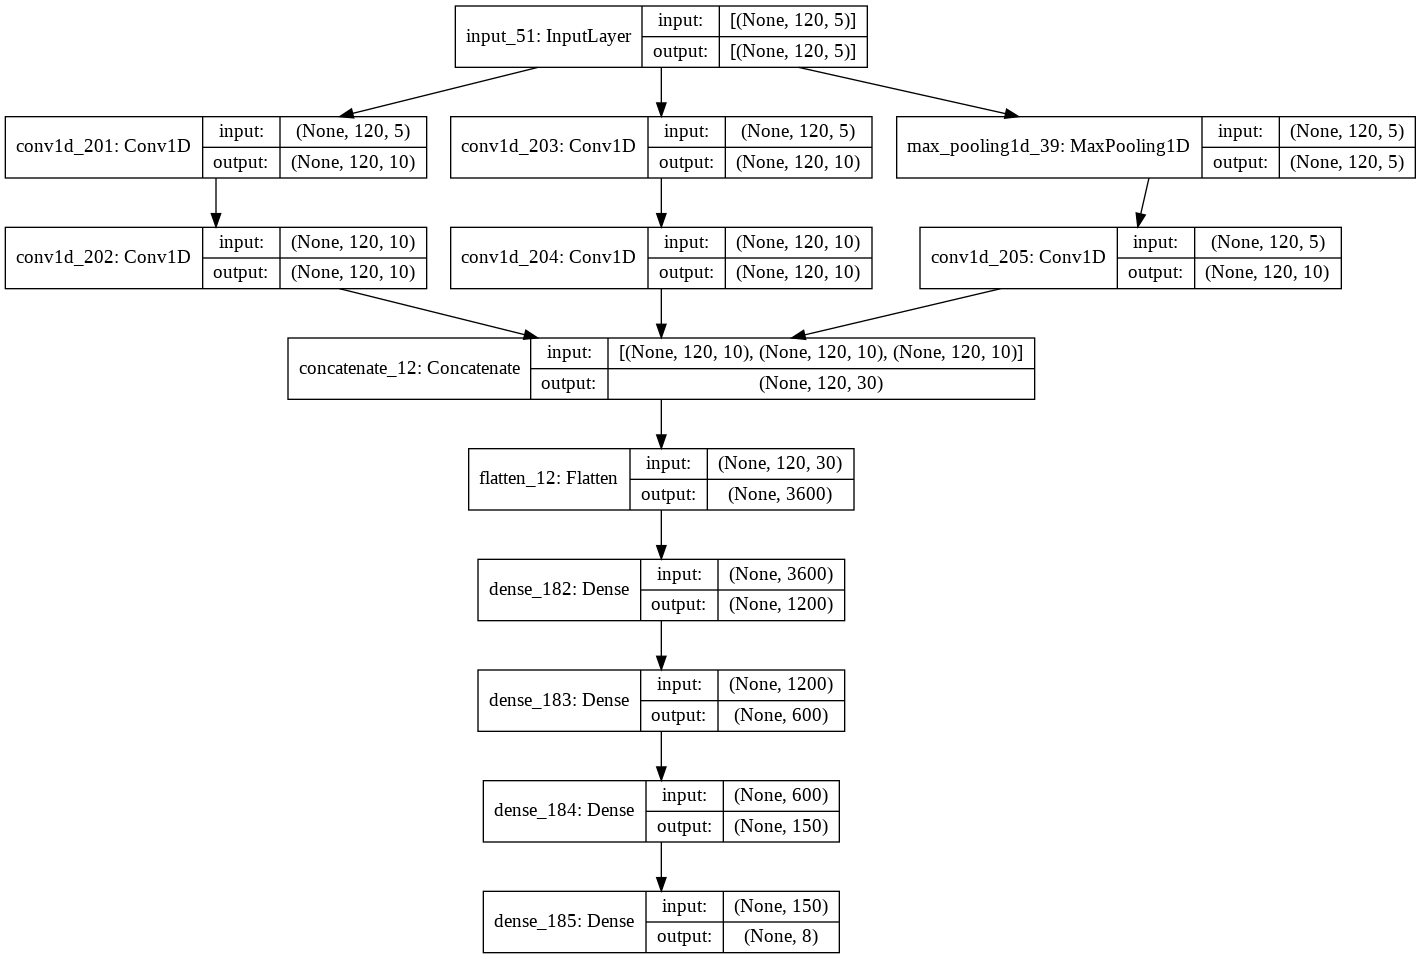

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)


In [ ]:
model.summary()

Model: "model_43"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_52 (InputLayer)           [(None, 120, 5)]     0                                            
__________________________________________________________________________________________________
conv1d_206 (Conv1D)             (None, 120, 5)       30          input_52[0][0]                   
__________________________________________________________________________________________________
conv1d_208 (Conv1D)             (None, 120, 5)       30          input_52[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_40 (MaxPooling1D) (None, 120, 5)       0           input_52[0][0]                   
___________________________________________________________________________________________

In [ ]:
result = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), \
                steps_per_epoch = STEP_SIZE_TRAIN, validation_steps = STEP_SIZE_VALID,\
                epochs = 120, class_weight = w, shuffle=True, verbose=2, callbacks = [check, es])

Epoch 1/120
178/178 - 14s - loss: 18.4999 - accuracy: 0.2823 - val_loss: 2.1765 - val_accuracy: 0.2252

Epoch 00001: val_loss improved from inf to 2.17653, saving model to /content/gdrive/My Drive/Models/SWINGS/w_categ_hyperopt_oneshot_inception.hdf5
Epoch 2/120
178/178 - 7s - loss: 0.1133 - accuracy: 0.6166 - val_loss: 0.8447 - val_accuracy: 0.6387

Epoch 00002: val_loss improved from 2.17653 to 0.84469, saving model to /content/gdrive/My Drive/Models/SWINGS/w_categ_hyperopt_oneshot_inception.hdf5
Epoch 3/120
178/178 - 7s - loss: 0.0797 - accuracy: 0.7261 - val_loss: 0.6366 - val_accuracy: 0.7419

Epoch 00003: val_loss improved from 0.84469 to 0.63663, saving model to /content/gdrive/My Drive/Models/SWINGS/w_categ_hyperopt_oneshot_inception.hdf5
Epoch 4/120
178/178 - 7s - loss: 0.0676 - accuracy: 0.7728 - val_loss: 0.4957 - val_accuracy: 0.8324

Epoch 00004: val_loss improved from 0.63663 to 0.49570, saving model to /content/gdrive/My Drive/Models/SWINGS/w_categ_hyperopt_oneshot_incep